# 1. Import packages and collect data

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [6]:
# pip install spacy==2.2.3
!python -m spacy download en_core_web_lg
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install mlxtend

!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180943 sha256=c68cfc729e9ca8b675445b172e82faf51bb635e0ae100ce2ee73954f854df8c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-9a20r2nq/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [78]:
import pandas as pd
import numpy as np
import spacy

import preprocess_kgptalkie as ps
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam

from mlxtend.plotting import plot_confusion_matrix

In [11]:
dataset_link = 'https://raw.githubusercontent.com/laxmimerit/NLP-Tutorial-8---Sentiment-Classification-using-SpaCy-for-IMDB-and-Amazon-Review-Dataset/master/datasets/imdb_labelled.txt'

df = pd.read_csv(dataset_link,sep = '\t', header = None)
df.columns = ['reviews','sentiment']

In [12]:
#Preview our dataset
df.head()

,reviews,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


# 2. Data preprocessing

The reviews from the dataset still have some issues we have to deal with, such as special characters and upper case characters.

## 2.1. Remove unneccessary information from the reviews

In [13]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x) #convert contraction word to expansion word
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x) #remove retweet if any
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [16]:
df['reviews'] = df['reviews'].apply(lambda x: get_clean(x))

In [19]:
df.head(5)

,reviews,sentiment
0,a very very very slowmoving aimless movie abou...,0
1,not sure who was more lost the flat characters...,0
2,attempting artiness with black white and cleve...,0
3,very little music or anything to speak of,0
4,the best scene in the movie was when gerardo i...,1


## 2.2. Get the word2vec

The word2vec method helps us create 300 dimensional vectors, each of which representing a review.

In [20]:
import en_core_web_lg

In [21]:
nlp = en_core_web_lg.load()

In [22]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [24]:
df['vec'] = df['reviews'].apply(lambda x: get_vec(x))

In [25]:
df.head()

,reviews,sentiment,vec
0,a very very very slowmoving aimless movie abou...,0,"[-0.065427616, 0.105150685, -0.23944347, 0.127..."
1,not sure who was more lost the flat characters...,0,"[0.07790671, 0.1754548, -0.14305861, -0.021857..."
2,attempting artiness with black white and cleve...,0,"[-0.1621301, 0.004197893, -0.11855656, -0.1021..."
3,very little music or anything to speak of,0,"[-0.09093174, 0.25162372, -0.25681874, 0.15846..."
4,the best scene in the movie was when gerardo i...,1,"[0.08769195, 0.12695198, -0.097915664, -0.0435..."


We still need to reshape the data in our vec column so that we can prepare our train and test sets

In [26]:
y = df['sentiment']

X = df['vec'].to_numpy()

In [28]:
#Let's reshape X
X = X.reshape((1,-1))
X = np.concatenate(np.concatenate(X,axis = 0), axis = 0).reshape(-1,300)

In [29]:
# X = np.concatenate(np.concatenate(X,axis = 0), axis = 0).reshape(-1,300)

In [30]:
df.shape,X.shape

((748, 3), (748, 300))

Now, we finally have 300-dim vectors that represent our reviews.

## 2.3. Prepare train set and test set

In [32]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1, stratify = y)

In [34]:
X_train.shape,X_test.shape

((598, 300), (150, 300))

In [35]:
np.min(X_train)

-2.7673

In [36]:
np.max(X_train)

2.7844598

## 2.4. Features Standardization

Let's standardize our dataset to 0-1 scale

In [38]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
np.min(X_train)

0.0

In [40]:
np.max(X_train)

1.0000001

# 3. Build and Train an ANN model

In [43]:
model = Sequential()
model.add(Dense(units = 128, activation = 'relu',input_dim = X.shape[1]))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#compile the model
model.compile(optimizer = Adam(learning_rate = 0.0005),loss = 'binary_crossentropy',metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [44]:
model.fit(X_train,y_train,batch_size = 4, epochs = 20)

Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 0.7026 - accuracy: 0.4849
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.6507 - accuracy: 0.6120
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.5588 - accuracy: 0.7157
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.4805 - accuracy: 0.7609
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.4697 - accuracy: 0.7759
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.4036 - accuracy: 0.8094
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.3820 - accuracy: 0.8211
Epoch 8/20
150/150 [==============================] - 0s 2ms/step - loss: 0.3837 - accuracy: 0.8211
Epoch 9/20
150/150 [==============================] - 0s 2ms/step - loss: 0.3745 - accuracy: 0.8227
Epoch 10/20
150/150 [==============================] - 0s 2ms/step - loss: 0.3552 - accuracy: 0.8395

# 4. Text the model

In [59]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

In [60]:
confusion_matrix(y_test,y_pred)

array([[66,  7],
       [25, 52]])

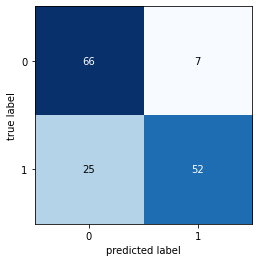

In [63]:
plot_confusion_matrix(confusion_matrix(y_test,y_pred))
plt.show()

In [65]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.90      0.80        73
           1       0.88      0.68      0.76        77

    accuracy                           0.79       150
   macro avg       0.80      0.79      0.78       150
weighted avg       0.81      0.79      0.78       150



## 4.1. Setting custom Threshold

In [66]:
from sklearn.metrics import precision_score,recall_score

In [68]:
y_pred = model.predict(X_test)
# y_pred = (model.predict(X_test) > 0.7).astype("int32")

for i in [0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75]:
  classes = [1 if val > i else 0 for val in y_pred]
  print(i, '-->>', round(precision_score(y_test,classes),3), round(recall_score(y_test,classes),3))

0.3 -->> 0.855 0.766
0.35 -->> 0.868 0.766
0.4 -->> 0.887 0.714
0.45 -->> 0.885 0.701
0.5 -->> 0.881 0.675
0.55 -->> 0.879 0.662
0.6 -->> 0.875 0.636
0.65 -->> 0.873 0.623
0.7 -->> 0.9 0.584
0.75 -->> 0.898 0.571


# 5. 1-D CNN model building and training

In [70]:
X_train.shape

(598, 300)

In [71]:
X_train_c = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test_c = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [75]:
X_train_c.shape,X_test_c.shape

((598, 300, 1), (150, 300, 1))

In [76]:
X_train_c[0].shape

(300, 1)

In [87]:
model = Sequential()
model.add(Conv1D(32, 2,activation = 'relu',input_shape = X_train_c[0].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,activation ='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'sigmoid'))

In [83]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 299, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 299, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 299, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9568)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                612416    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [88]:
epochs = 20
model.compile(optimizer = Adam(0.0001), loss = 'binary_crossentropy',metrics = ['accuracy'])
history = model.fit(X_train_c,y_train,epochs = epochs,validation_data = (X_test_c,y_test))

Epoch 1/20
19/19 [==============================] - 1s 32ms/step - loss: 0.6405 - accuracy: 0.6304 - val_loss: 0.6769 - val_accuracy: 0.5200
Epoch 2/20
19/19 [==============================] - 0s 22ms/step - loss: 0.4362 - accuracy: 0.7960 - val_loss: 0.6615 - val_accuracy: 0.5467
Epoch 3/20
19/19 [==============================] - 1s 27ms/step - loss: 0.3384 - accuracy: 0.8495 - val_loss: 0.6466 - val_accuracy: 0.6000
Epoch 4/20
19/19 [==============================] - 0s 25ms/step - loss: 0.3250 - accuracy: 0.8528 - val_loss: 0.6376 - val_accuracy: 0.6067
Epoch 5/20
19/19 [==============================] - 1s 29ms/step - loss: 0.2818 - accuracy: 0.8946 - val_loss: 0.6272 - val_accuracy: 0.6600
Epoch 6/20
19/19 [==============================] - 0s 26ms/step - loss: 0.2679 - accuracy: 0.8997 - val_loss: 0.6147 - val_accuracy: 0.7333
Epoch 7/20
19/19 [==============================] - 1s 27ms/step - loss: 0.2521 - accuracy: 0.9130 - val_loss: 0.6037 - val_accuracy: 0.7800
Epoch 8/20
19

In [89]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

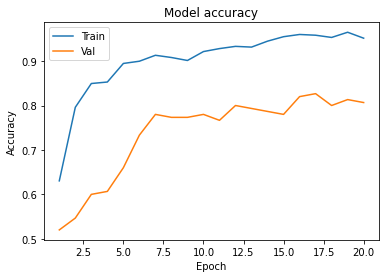

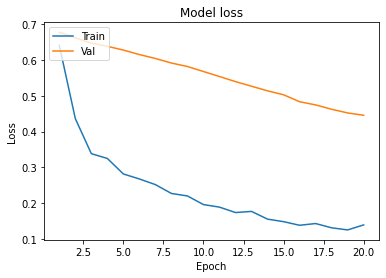

In [90]:
plot_learningCurve(history, epochs)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb648d6a3d0>)

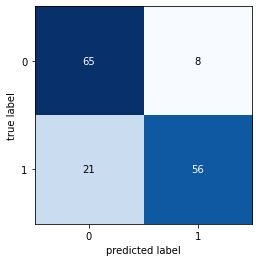

In [96]:
plot_confusion_matrix(confusion_matrix(y_test,(model.predict(X_test_c) > 0.5).astype("int32")))

## 5.2. Model Load, store and testing

In [91]:
from tensorflow.keras.models import load_model

In [92]:
model.save('cnn_model',save_format= 'h5')

In [93]:
model = load_model('cnn_model')

Test the model

In [102]:
def get_pred(x,model, scaler,threshold = 0.5):
  x = get_clean(x)
  vec = get_vec(x).reshape(1,-1)
  vec = scaler.transform(vec)
  vec = vec.reshape(-1,300,1)
  y_pred = (model.predict(vec) > threshold).astype("int32")

  print(y_pred[0])

In [103]:
x = 'it was a nice movie!'
get_pred(x,model,scaler)

[1]
